# Analysis of Ngn2x3HA-P2A-mRuby2 vs. CellTrace-Violet on 4 dpi

Notes:

1. Replated at 4 dpi at 10k/96-well
2. These were CTV stained at 1 dpi, 1:1000 (1 µM) for 30 min at 37C, then washed with DMEM/FBS 
3. All are using uORFwx1

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker
import seaborn as sns
import scipy
from statannotations.Annotator import Annotator
import rushd as rd
import re
from pathlib import Path
import yaml

# Required descriptors for annotate
from scipy.stats import ttest_ind
from statannotations.stats.StatTest import StatTest

# 4 dpi data
## Load data

In [2]:
# Directories
base_datadir = rd.datadir/'2024.04.18_Ngn2-CTV-sort_1-4'
figpath = '../figures/fig6/'

dir_list = ['2024.03.19_Ngn2sort_1', '2024.04.18_Ngn2sort_2', '2024.09.03_Ngn2sort_4']

# List of ctrls
ctrl_list = ['Ctrl-neg', 'Ctrl-puro', 'Ctrl-mRuby2', 'Ctrl-eGFP']

# Store all data in list of dfs which will be converted to df at end
data_4dpi_P3 = list()
data_4dpi_mRuby2 = list()

# For P3
for j, dir in enumerate(dir_list):
    # P3 - get all CSVs
    datadir_P3 = base_datadir/dir/'export_P3'
    files = Path(datadir_P3).glob('*.csv') 

    for i, file in enumerate(files):

        # Extract metadata from csv title
        match = re.search(
            'export_Specimen_001_(?P<cond>.+)_P3.csv', file.name)

        # Load as df and note header is on 0th row
        df = pd.read_csv(file, header=0)
        if dir == '2024.04.18_Ngn2sort_2':
            df.rename(columns={'Pacific Blue-A': 'BV 421-A'}, inplace=True)

        # Update columns in df with metadata from file name
        df['cond'] = match.group('cond')
        df['rep'] = j
        data_4dpi_P3.append(df)

# mRuby2 - get all CSVs
# For P3
for j, dir in enumerate(dir_list):
    print(j, dir)
    # P3 - get all CSVs
    datadir_mRuby2 = base_datadir/dir/'export_mRuby2+'
    files = Path(datadir_mRuby2).glob('*.csv') 
    for i, file in enumerate(files):

        # Extract metadata from csv title
        match = re.search(
            'export_Specimen_001_(?P<cond>.+)_(?P<subset>.+).csv', file.name)

        # Load as df and note header is on 0th row
        df = pd.read_csv(file, header=0)
        if dir == '2024.04.18_Ngn2sort_2':
            df.rename(columns={'Pacific Blue-A': 'BV 421-A'}, inplace=True)

        # Update columns in df with metadata from file name
        df['cond'] = match.group('cond')
        df['rep'] = j
        data_4dpi_mRuby2.append(df)

# Convert list of dfs into single df
data_4dpi_P3 = pd.concat(data_4dpi_P3, ignore_index=True)
data_4dpi_mRuby2 = pd.concat(data_4dpi_mRuby2, ignore_index=True)

# Remove negative data
data_4dpi_P3 = data_4dpi_P3.loc[
    (data_4dpi_P3['PE-Texas Red-A'] > 0) &
    (data_4dpi_P3['FITC-A'] > 0) & 
    (data_4dpi_P3['BV 421-A'] > 0)
]
data_4dpi_mRuby2 = data_4dpi_mRuby2.loc[
    (data_4dpi_mRuby2['PE-Texas Red-A'] > 0) &
    (data_4dpi_mRuby2['FITC-A'] > 0) & 
    (data_4dpi_mRuby2['BV 421-A'] > 0)
]

# Separate out ctrl and sample data for mRuby2+
data_4dpi_mRuby2_ctrl = data_4dpi_mRuby2[ data_4dpi_mRuby2['cond'].isin(ctrl_list) ]
data_4dpi_mRuby2 = data_4dpi_mRuby2[ data_4dpi_mRuby2['cond'] == 'main' ]

0 2024.03.19_Ngn2sort_1
1 2024.04.18_Ngn2sort_2
2 2024.09.03_Ngn2sort_4


## Categorize cells

## Proliferation using CellTrace-Violet (BV 421 or BV421)

In [3]:
# Get CTV-low threshold for each rep s.t.
# CTV_low_thresh = 20% dimmest in ctrl
rep_list = data_4dpi_mRuby2.rep.unique()
CTV_low_thresh_list = np.zeros(np.shape(rep_list))
for (i, rep) in enumerate(rep_list):
    CTV_low_thresh_list[i] = np.percentile(
        data_4dpi_P3.loc[(data_4dpi_P3['cond'] == 'Ctrl-puro') &
            (data_4dpi_P3['rep'] == rep)
        ]['BV 421-A'], 20)

# Categorize based on CTV for each replicate
data_4dpi_mRuby2['CTV_cat'] = 'non-CTV-low'
for (i, rep) in enumerate(rep_list):
    data_4dpi_mRuby2.loc[
        (data_4dpi_mRuby2['rep'] == rep_list[i]) &
        (data_4dpi_mRuby2['BV 421-A'] < CTV_low_thresh_list[i]),
        'CTV_cat'] = 'CTV-low'

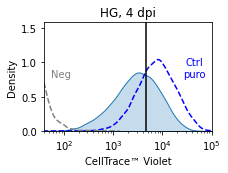

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))

# Plot CTV
x = 'BV 421-A'
rep = 1

sns.kdeplot(data=data_4dpi_mRuby2.loc[(data_4dpi_mRuby2['cond'] == 'main') & (data_4dpi_mRuby2['rep'] == rep)],
    ax=ax, x=x,
    common_norm=False, log_scale=(True, False),
    fill=True)

# Plot CTV control
sns.kdeplot(data=data_4dpi_P3[(data_4dpi_P3['cond'] == 'Ctrl-puro') & (data_4dpi_P3['rep'] == rep)], x=x, common_norm=False,
            ax=ax, log_scale=(True, False), color='blue', fill=False, linestyle='--')
ax.annotate('Ctrl\npuro', (0.9, 0.5), color='blue' , xycoords='axes fraction', ha='center')

# Plot neg ctrl
sns.kdeplot(data=data_4dpi_P3[(data_4dpi_P3['cond'] == 'Ctrl-neg') & ((data_4dpi_P3['rep'] == rep))], x=x, common_norm=False,
            ax=ax, log_scale=(True, False), color='grey', fill=False, linestyle='--')
ax.annotate('Neg', (0.1, 0.5), color='grey', xycoords='axes fraction', ha='center')

# Plot threshold
i = 0
ax.axvline(CTV_low_thresh_list[i], 0, 1, color='black')

# Title
plt.title('HG, 4 dpi')
ax.set_xlabel('CellTrace™ Violet')
# Adjust limits
CTV_lim = (40, 1*10**5)
for sub_ax in plt.gcf().get_axes():
    sub_ax.set_xlim(CTV_lim)

## Ngn2x3HA using mRuby2 (PE-Texas Red)

Text(0.5, 0, 'mRuby2')

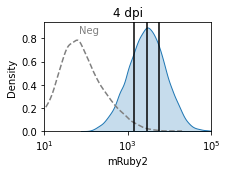

In [5]:
# General plotting params
x = 'PE-Texas Red-A'

# Plot
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
sns.kdeplot(data=data_4dpi_mRuby2,
    ax=ax, x=x, 
    common_norm=False, log_scale=(True, False),
    fill=True)

# Plot neg ctrl
sns.kdeplot(data=data_4dpi_P3[(data_4dpi_P3['cond'] == 'Ctrl-neg')], x=x, common_norm=False,
            ax=ax, log_scale=(True, False), color='grey', fill=False, linestyle='--')
ax.annotate('Neg', (0.27, 0.9), color='grey', xycoords='axes fraction', ha='center')

# Plot mRuby2 gating levels for hyperP cells
mRuby2 = data_4dpi_mRuby2['PE-Texas Red-A']
# Mark mRuby2 quartiles of hyperP cells
mRuby2_thresh_list = [np.percentile(mRuby2, 25), np.percentile(mRuby2, 50), np.percentile(mRuby2, 75)]
for mRuby2_thresh in mRuby2_thresh_list:
    ax.axvline(mRuby2_thresh, 0, 1, color='black')

# Title
plt.title('4 dpi')
# Adjust limits
mRuby2_lim = (10, 1*10**5)
for sub_ax in plt.gcf().get_axes():
    sub_ax.set_xlim(mRuby2_lim)

# Format
ax.xaxis.set_label_text('mRuby2')

In [6]:
# Get mRuby2 threshold for each rep for each quartile (25%, 50%, 75%)
rep_list = data_4dpi_mRuby2.rep.unique()
mRuby2_thresh_list = np.zeros((len(rep_list), 3))
for (i, rep) in enumerate(rep_list):

    # Mark mRuby2 quartiles
    mRuby2 = data_4dpi_mRuby2.loc[(data_4dpi_mRuby2.rep == rep), 'PE-Texas Red-A']
    mRuby2_thresh_list[i, :] = [np.percentile(mRuby2, 25), np.percentile(mRuby2, 50), np.percentile(mRuby2, 75)]

In [7]:
# Categorize based on mRuby2 for each replicate
data_4dpi_mRuby2.loc[:, 'mRuby2_cat'] = 'None'
for (i, rep) in enumerate(rep_list):
    # Low
    data_4dpi_mRuby2.loc[
        (data_4dpi_mRuby2['rep'] == rep_list[i]) &
        (data_4dpi_mRuby2['PE-Texas Red-A'] < mRuby2_thresh_list[i, 0]),
        'mRuby2_cat'] = 'mRuby2-low'
    # Med
    data_4dpi_mRuby2.loc[
        (data_4dpi_mRuby2['rep'] == rep_list[i]) &
        (data_4dpi_mRuby2['PE-Texas Red-A'] > mRuby2_thresh_list[i, 1]),
        'mRuby2_cat'] = 'mRuby2-med'
    # High
    data_4dpi_mRuby2.loc[
        (data_4dpi_mRuby2['rep'] == rep_list[i]) &
        (data_4dpi_mRuby2['PE-Texas Red-A'] > mRuby2_thresh_list[i, 2]),
        'mRuby2_cat'] = 'mRuby2-high'
    
# Get total counts and percent of eGFP-H+
group = ['cond', 'rep']
count_df = data_4dpi_mRuby2.groupby([*group, 'CTV_cat', 'mRuby2_cat'])[
    'FSC-A'].count().rename('count')

percent_df_4dpi = (count_df*100/count_df.groupby([*group]).transform('sum')).dropna().reset_index(name='percent')

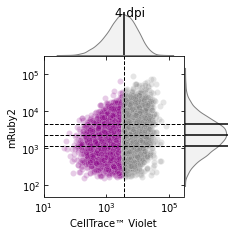

In [10]:
palette = {'CTV-low': '#8b0288',
           'non-CTV-low': 'gray'}

# What to plot
x = 'BV 421-A'
y = 'PE-Texas Red-A'
rep = 1
mRuby2_thresh =  mRuby2_thresh_list[rep, :] 
df = data_4dpi_mRuby2[data_4dpi_mRuby2.rep == rep]

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# Set up figure
fig = plt.figure(figsize=(3, 3))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)

ax_histx = plt.axes(rect_histx)
ax_histy = plt.axes(rect_histy)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy.tick_params(direction='in', labelleft=False)
ax_histx.set_axis_off()
ax_histy.set_axis_off()

# Set limits
CTV_lim = (10, 3*1e5)
mRuby2_lim = (50, 3*1e5)
xlim = CTV_lim
ylim = mRuby2_lim
ax_scatter.set_xlim(xlim)
ax_scatter.set_ylim(ylim)
ax_histx.set_xlim(xlim)
ax_histy.set_ylim(ylim)
ax_scatter.set_yscale('log')
ax_scatter.set_xscale('log')

# Plot CTV-low
CTV_cat = 'CTV-low'
sns.scatterplot(ax=ax_scatter, data=df[df.CTV_cat == CTV_cat],
    x=x, y=y,
    color=palette[CTV_cat], alpha=0.2, legend=False)

CTV_cat = 'non-CTV-low'
sns.scatterplot(ax=ax_scatter, data=df[df.CTV_cat == CTV_cat],
    x=x, y=y,
    color=palette[CTV_cat], alpha=0.2, legend=False)

# Plot histograms
sns.kdeplot(ax=ax_histx, data=df, x=x, alpha=0.1,
    log_scale=True, fill=True, common_norm=False, legend=False, color=palette[CTV_cat])
sns.kdeplot(ax=ax_histy, data=df, y=y, alpha=0.1,
    log_scale=True, fill=True, common_norm=False, legend=True, color=palette[CTV_cat])

# Add in lines
ax_scatter.axvline(CTV_low_thresh_list[rep], color='black', linestyle='dashed', linewidth=1)
ax_scatter.axhline(mRuby2_thresh[0], color='black', linestyle='dashed', linewidth=1)
ax_scatter.axhline(mRuby2_thresh[1], color='black', linestyle='dashed', linewidth=1)
ax_scatter.axhline(mRuby2_thresh[2], color='black', linestyle='dashed', linewidth=1)

ax_histx.axvline(CTV_low_thresh_list[rep], color='black')
ax_histy.axhline(mRuby2_thresh[0], color='black')
ax_histy.axhline(mRuby2_thresh[1], color='black')
ax_histy.axhline(mRuby2_thresh[2], color='black')

# Relabel
# ax_scatter.set_yticks([10, 1e3, 1e5])
ax_scatter.minorticks_off()
ax_scatter.set_xlabel('CellTrace™ Violet')
ax_scatter.set_ylabel('mRuby2')

plt.suptitle('4 dpi')
# plt.savefig(figpath + '4dpi_CTV-v-mRuby2.svg', bbox_inches='tight')

/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

mRuby2-med_non-CTV-low vs. mRuby2-med_CTV-low: t-test independent samples, P_val:1.390e-01 t=-1.844e+00
mRuby2-low_non-CTV-low vs. mRuby2-low_CTV-low: t-test independent samples, P_val:4.632e-05 t=-1.888e+01
mRuby2-high_non-CTV-low vs. mRuby2-high_CTV-low: t-test independent samples, P_val:1.436e-02 t=4.141e+00


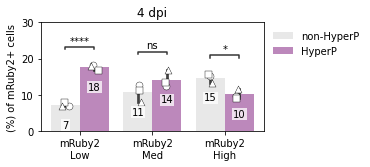

In [ ]:
# General plotting params
x = 'mRuby2_cat'
y = 'percent'
hue = 'CTV_cat'
units = 'rep'
marker_list = ['o', 's', '^', 'D', 'P', 'X'] 

order = ['mRuby2-low', 'mRuby2-med', 'mRuby2-high']
hue_order = ['non-CTV-low', 'CTV-low']

palette = {'CTV-low': '#8b0288',
           'non-CTV-low': 'lightgray'}

fig, ax = plt.subplots(1, 1, figsize=(4, 2))

# Plot bar plot
g = sns.barplot(
    ax=ax, data=percent_df_4dpi,
    x=x, y=y, units=units, hue=hue,
    order=order, hue_order=hue_order,
    palette=palette, alpha=0.5)

# Plot reps
for (i, rep) in enumerate(percent_df_4dpi.rep.unique()):
    sns.stripplot(ax=ax, data=percent_df_4dpi[percent_df_4dpi.rep == rep],
        x=x, y=y, order=order,
        dodge=True, marker=marker_list[i],
        hue=hue, hue_order=hue_order,
        palette={'CTV-low':'white', 'non-CTV-low':'white'}, size=7,
        edgecolor='black', linewidth=0.4,)
    

# Format
plt.title('4 dpi')
ax.set_xlabel('')
ax.yaxis.set_label_text('(%) of mRuby2+ cells')
ax.set_yticks(np.arange(0, 31, 10))
ax.set_xticklabels(['mRuby2\nLow', 'mRuby2\nMed', 'mRuby2\nHigh'])

# Adjust legend
lmap = {'CTV-low':'HyperP', 'non-CTV-low':'non-HyperP'}
h,l = ax.get_legend_handles_labels()
sns.move_legend(ax, handles=h[-len(hue_order):], labels=[lmap[i] for i in l[-len(hue_order):]],
    title='', loc='upper left', bbox_to_anchor=(1,1), frameon=False)

# Formatting
for sub_ax in plt.gcf().get_axes():
    # Add barplot labels
    for i in sub_ax.containers:
        bar_labels = sub_ax.bar_label(i, fmt='%0.0f', padding=-25)
        for label in bar_labels:
            label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))   

# Pairs for stats comp
pairs = [((mRuby2_cat, 'CTV-low'), (mRuby2_cat, 'non-CTV-low')) for mRuby2_cat in order]
# Add in stats for iMN yield
annot = Annotator(ax=ax,
    data=percent_df_4dpi, pairs=pairs,
    x=x, y=y,
    hue=hue, order=order, hue_order=hue_order)
annot.configure(test='t-test_ind', text_format='star', loc='inside', verbose=2)
annot.apply_test().annotate(line_offset_to_group=0.15)

# plt.savefig(figpath + '4dpi_CTV_mRuby2_percents.svg', bbox_inches='tight')

# 14 dpi data

## Load data

In [12]:
# Directories
base_datadir = rd.datadir/'2024.03.29_HG_Ngn2-sort_14dpi_1-5'

# List of data folder names
dir_list = ['2024.03.29_HG_Ngn2-sort_14dpi_1', '2024.04.28_HG_Ngn2-sort_14dpi_2', '2024.09.13_HG_Ngn2-sort_14dpi_4']

# Store all data in list of dfs which will be converted to df at end
data_14dpi_all = list()

# get all csvs for each dir
for (j, dir_name) in enumerate(dir_list):

    rep = int(dir_name[-1])
    # Load as df and note header is on 0th row
    df = rd.flow.load_csv_with_metadata(
        base_datadir/dir_name/'export_singlets', base_datadir/f'well_metadata_{rep}.yaml')
    df['rep'] = rep
    data_14dpi_all.append(df)

# Convert list of dfs into single df
data_14dpi_all = pd.concat(data_14dpi_all, ignore_index=True)

# Remove negative data
data_14dpi_all = data_14dpi_all.loc[
    (data_14dpi_all['FSC-A'] > 0) &
    (data_14dpi_all['eGFP-A'] > 0) &
    (data_14dpi_all['mRuby2-A'] > 0) &
    (data_14dpi_all['CellTrace™ Violet-A'] > 0)
]

# List of ctrls and samples
ctrl_list = ['Ctrl-puro', 'Ctrl-mRuby2', 'Ctrl-eGFP', 'Ctrl-neg']
cond_list = ['mRuby2-low, nonHyperP', 'mRuby2-med, nonHyperP',  'mRuby2-high, nonHyperP','mRuby2-low, HyperP','mRuby2-med, HyperP', 'mRuby2-high, HyperP', 'bulk']

# Separate out ctrl and sample data
data_14dpi_ctrl = data_14dpi_all[ data_14dpi_all['cond'].isin(ctrl_list) ]
data_14dpi = data_14dpi_all[ data_14dpi_all['cond'].isin(cond_list) ]

## Look at iMNs

### Gate

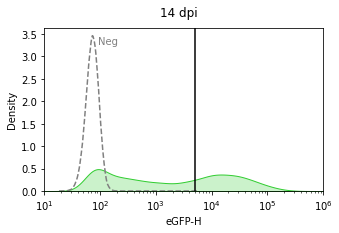

In [13]:
# Threshold for iMNs
eGFP_H_thresh = 5*10**3

fig, ax = plt.subplots(1, 1, figsize=(5, 3))

# Plot eGFP-H
x = 'eGFP-H'
hue = 'cond'

sns.kdeplot(ax=ax, data=data_14dpi_all.loc[data_14dpi_all.cond == 'mRuby2-med, HyperP'],
    x=x, color='limegreen',
    common_norm=False, log_scale=(True, False),
    fill=True)

# Plot neg ctrl
sns.kdeplot(data=data_14dpi_ctrl[(data_14dpi_ctrl['cond'] == 'Ctrl-neg')], x=x, common_norm=False,
            ax=ax, log_scale=(True, False), color='grey', fill=False, linestyle='--')
ax.annotate('Neg', (0.23, 0.9), color='grey', xycoords='axes fraction', ha='center')

# Title
plt.suptitle('14 dpi')
# Adjust limits
eGFP_lim = (10, 1*10**6)
for sub_ax in plt.gcf().get_axes():
    sub_ax.set_xlim(eGFP_lim)

sub_ax.axvline(eGFP_H_thresh, 0, 1, color='black')

In [14]:
# Categorize iMNs based on eGFP_thresh
data_14dpi['eGFP_cat'] = 'fib'
data_14dpi.loc[(data_14dpi['eGFP-H'] > eGFP_H_thresh), 'eGFP_cat'] = 'iMN'

# Get total counts and percent of eGFP-H+
well_group = ['cond', 'rep']
count_df_reps = data_14dpi.groupby([*well_group, 'well', 'eGFP_cat'])[
    'FSC-A'].count().unstack(fill_value=0).stack().rename('count') # Puts 0 if no eGFP-H+ rather than dropping row
percent_df_reps = (count_df_reps*100/count_df_reps.groupby([*well_group, 'well']).transform('sum')).dropna().reset_index(name='percent')

# Extract just the iMNs
data_iMN_percent_reps = percent_df_reps.loc[(percent_df_reps['eGFP_cat'] == 'iMN')]

# Get iMN yield per condition
seedNum = 10**4 # Seeded 10k MEFs/96-wel
# Divide by seeded cells to get yield, then extract just the iMNs
data_iMN_yield_reps = (count_df_reps*100/seedNum).reset_index(name='yield')
data_iMN_yield_reps = data_iMN_yield_reps.loc[data_iMN_yield_reps['eGFP_cat'] == 'iMN']

# Reduce to bio reps
data_iMN_percent = data_iMN_percent_reps.groupby(well_group)['percent'].mean().reset_index()
data_iMN_yield = data_iMN_yield_reps.groupby(well_group)['yield'].mean().reset_index()

/var/folders/2d/h4qyrjcd68x7g4p2qdv30s8h0000gn/T/ipykernel_80193/3079664238.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_14dpi['eGFP_cat'] = 'fib'
/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


### Look at iMN purity

In [15]:
data_iMN_percent_hyperPvnon_reps = data_iMN_percent_reps.copy()

paired_map = {
    'bulk': ('bulk', ''),
    'mRuby2-low, nonHyperP': ('mRuby2-low', 'nonHyperP'),
    'mRuby2-med, nonHyperP': ('mRuby2-med', 'nonHyperP'),
    'mRuby2-high, nonHyperP':  ('mRuby2-high', 'nonHyperP'),
    'mRuby2-low, HyperP': ('mRuby2-low', 'HyperP'),
    'mRuby2-med, HyperP': ('mRuby2-med', 'HyperP'),
    'mRuby2-high, HyperP':('mRuby2-high', 'HyperP'),}

for index, row in data_iMN_percent_hyperPvnon_reps.iterrows():
    data_iMN_percent_hyperPvnon_reps.loc[index, 'main_cond'] = paired_map[row.cond][0]
    data_iMN_percent_hyperPvnon_reps.loc[index, 'hyperP_cat'] = paired_map[row.cond][1]

data_iMN_percent_hyperPvnon = data_iMN_percent_hyperPvnon_reps.groupby([ 'rep', 'main_cond', 'hyperP_cat'])['percent'].mean().reset_index()

/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)
/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same paramete

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

mRuby2-med_HyperP vs. mRuby2-high_nonHyperP: t-test independent samples, P_val:7.321e-03 t=5.033e+00
mRuby2-low_HyperP vs. mRuby2-high_nonHyperP: t-test independent samples, P_val:3.218e-01 t=1.184e+00


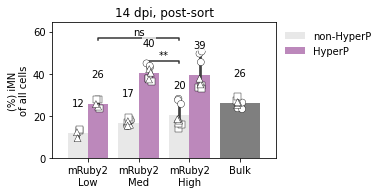

In [16]:
# General plotting params
x = 'main_cond'
y = 'percent'
hue = 'hyperP_cat'
units = 'rep'
marker_list = ['o', 's', '^', 'D', 'P', 'X'] 

order = ['mRuby2-low', 'mRuby2-med', 'mRuby2-high', 'bulk']
hue_order = ['nonHyperP', 'HyperP']

palette = {'HyperP': '#8b0288',
           'nonHyperP': 'lightgray'}

fig, ax = plt.subplots(1, 1, figsize=(4, 2.5))

# Plot bar plot
g = sns.barplot(
    ax=ax, data=data_iMN_percent_hyperPvnon_reps,
    x=x, y=y, units=units, hue=hue,
    order=order, hue_order=hue_order,
    palette=palette, alpha=0.5)

# Plot reps
for (i, rep) in enumerate(data_iMN_percent_hyperPvnon_reps.rep.unique()):
    sns.stripplot(ax=ax, data=data_iMN_percent_hyperPvnon_reps[data_iMN_percent_hyperPvnon_reps.rep == rep],
                x=x, y=y, order=order,
                dodge=True, marker=marker_list[i],
                hue=hue, hue_order=hue_order,
                palette={'HyperP':'white', 'nonHyperP':'white'}, size=7,
                edgecolor='black', linewidth=0.4,)
    

# Plot bar plot
g = sns.barplot(
    ax=ax, data=data_iMN_percent_hyperPvnon_reps,
    x=x, y=y, units=units,
    order=['', '', '', 'bulk'], 
    color='black', alpha=0.5)
for (i, rep) in enumerate(data_iMN_percent_hyperPvnon_reps.rep.unique()):
    sns.stripplot(ax=ax, data=data_iMN_percent_hyperPvnon_reps[data_iMN_percent_hyperPvnon_reps.rep == rep],
                x=x, y=y, order=['', '', '', 'bulk'],
                dodge=True, marker=marker_list[i],
                color='white', size=7,
                edgecolor='black', linewidth=0.4,)
    

# Format
plt.title('14 dpi, post-sort')
ax.set_xlabel('')
ax.yaxis.set_label_text('(%) iMN\nof all cells')
ax.set_yticks(np.arange(0, 65, 20))
ax.set_xlim((-0.7, 3.7))

ax.set_xticklabels(['mRuby2\nLow', 'mRuby2\nMed', 'mRuby2\nHigh', 'Bulk'])

# Adjust legend
lmap = {'HyperP':'HyperP', 'nonHyperP':'non-HyperP'}
h,l = ax.get_legend_handles_labels()
sns.move_legend(ax, handles=h[-len(hue_order):], labels=[lmap[i] for i in l[-len(hue_order):]],
    title='', loc='upper left', bbox_to_anchor=(1,1), frameon=False)

# Formatting
for sub_ax in plt.gcf().get_axes():
    # Add barplot labels
    for i in sub_ax.containers:
        bar_labels = sub_ax.bar_label(i, fmt='%0.0f', padding=25)
        for label in bar_labels:
            label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))   


# Pairs for stats comp
pairs = [(('mRuby2-low', 'HyperP'), ('mRuby2-high', 'nonHyperP')), (('mRuby2-med', 'HyperP'), ('mRuby2-high', 'nonHyperP'))]
# Add in stats for iMN yield
annot = Annotator(ax=ax,
    data=data_iMN_percent_hyperPvnon, pairs=pairs,
    x=x, y=y,
    hue=hue, order=order, hue_order=hue_order)
annot.configure(test='t-test_ind', text_format='star', loc='inside', verbose=2)
annot.apply_test().annotate(line_offset_to_group=0)

# fig.tight_layout()  # Helps improve white spacing
plt.savefig(figpath + 'iMN_percent.svg', bbox_inches='tight')

### Look at iMN yield

In [17]:
data_iMN_yield_hyperPvnon_reps = data_iMN_yield_reps.copy()

paired_map = {
    'bulk': ('bulk', ''),
    'mRuby2-low, nonHyperP': ('mRuby2-low', 'nonHyperP'),
    'mRuby2-med, nonHyperP': ('mRuby2-med', 'nonHyperP'),
    'mRuby2-high, nonHyperP':  ('mRuby2-high', 'nonHyperP'),
    'mRuby2-low, HyperP': ('mRuby2-low', 'HyperP'),
    'mRuby2-med, HyperP': ('mRuby2-med', 'HyperP'),
    'mRuby2-high, HyperP':('mRuby2-high', 'HyperP'),}

for index, row in data_iMN_yield_hyperPvnon_reps.iterrows():
    data_iMN_yield_hyperPvnon_reps.loc[index, 'main_cond'] = paired_map[row.cond][0]
    data_iMN_yield_hyperPvnon_reps.loc[index, 'hyperP_cat'] = paired_map[row.cond][1]

    bulk_yield = data_iMN_yield_hyperPvnon_reps[(data_iMN_yield_hyperPvnon_reps.cond == 'bulk') & (data_iMN_yield_hyperPvnon_reps.rep == row.rep)]['yield'].mean()
    data_iMN_yield_hyperPvnon_reps.loc[index, 'bulk yield'] = bulk_yield
    data_iMN_yield_hyperPvnon_reps.loc[index, 'norm yield'] = row['yield']/bulk_yield*100


data_iMN_yield_hyperPvnon = data_iMN_yield_hyperPvnon_reps.groupby([ 'rep', 'main_cond', 'hyperP_cat'])['yield'].mean().reset_index()


/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)
/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same paramete

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

mRuby2-med_HyperP vs. mRuby2-high_nonHyperP: t-test independent samples, P_val:9.691e-02 t=2.160e+00
mRuby2-low_HyperP vs. mRuby2-high_nonHyperP: t-test independent samples, P_val:4.044e-01 t=9.682e-01


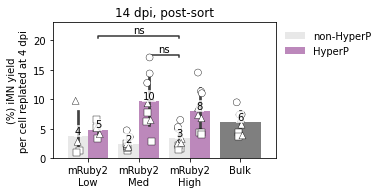

In [18]:
# General plotting params
x = 'main_cond'
y = 'yield'
hue = 'hyperP_cat'
units = 'rep'

order = ['mRuby2-low', 'mRuby2-med', 'mRuby2-high', 'bulk']
hue_order = ['nonHyperP', 'HyperP']

palette = {'HyperP': '#8b0288',
           'nonHyperP': 'lightgray'}

fig, ax = plt.subplots(1, 1, figsize=(4, 2.5))

# Plot bar plot
g = sns.barplot(
    ax=ax, data=data_iMN_yield_hyperPvnon_reps,
    x=x, y=y, units=units, hue=hue,
    order=order, hue_order=hue_order,
    palette=palette, alpha=0.5)

# Plot reps
for (i, rep) in enumerate(data_iMN_yield_hyperPvnon_reps.rep.unique()):
    sns.stripplot(ax=ax, data=data_iMN_yield_hyperPvnon_reps[data_iMN_yield_hyperPvnon_reps.rep == rep],
                x=x, y=y, order=order,
                dodge=True, marker=marker_list[i],
                hue=hue, hue_order=hue_order,
                palette={'HyperP':'white', 'nonHyperP':'white'}, size=7,
                edgecolor='black', linewidth=0.4,)
    

# Plot bulk plot
g = sns.barplot(
    ax=ax, data=data_iMN_yield_hyperPvnon_reps,
    x=x, y=y, units=units,
    order=['', '', '', 'bulk'], 
    color='black', alpha=0.5)
for (i, rep) in enumerate(data_iMN_yield_hyperPvnon_reps.rep.unique()):
    sns.stripplot(ax=ax, data=data_iMN_yield_hyperPvnon_reps[data_iMN_yield_hyperPvnon_reps.rep == rep],
                x=x, y=y, order=['', '', '', 'bulk'],
                dodge=True, marker=marker_list[i],
                color='white', size=7,
                edgecolor='black', linewidth=0.4,)
    

# Format
plt.title('14 dpi, post-sort')
ax.set_xlabel('')
ax.yaxis.set_label_text('(%) iMN yield\nper cell replated at 4 dpi')
# ax.set_yticks(np.arange(0, 30, 10))
ax.set_xlim((-0.7, 3.7))

ax.set_xticklabels(['mRuby2\nLow', 'mRuby2\nMed', 'mRuby2\nHigh', 'Bulk'])

# Adjust legend
lmap = {'HyperP':'HyperP', 'nonHyperP':'non-HyperP'}
h,l = ax.get_legend_handles_labels()
sns.move_legend(ax, handles=h[-len(hue_order):], labels=[lmap[i] for i in l[-len(hue_order):]],
    title='', loc='upper left', bbox_to_anchor=(1,1), frameon=False)

# Formatting
for sub_ax in plt.gcf().get_axes():
    # Add barplot labels
    for i in sub_ax.containers:
        bar_labels = sub_ax.bar_label(i, fmt='%0.0f', padding=0)
        for label in bar_labels:
            label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))   

# Pairs for stats comp
pairs = [(('mRuby2-low', 'HyperP'), ('mRuby2-high', 'nonHyperP')), (('mRuby2-med', 'HyperP'), ('mRuby2-high', 'nonHyperP'))]
# Add in stats for iMN yield
annot = Annotator(ax=ax,
    data=data_iMN_yield_hyperPvnon, pairs=pairs,
    x=x, y=y,
    hue=hue, order=order, hue_order=hue_order)
annot.configure(test='t-test_ind', text_format='star', loc='inside', verbose=2)
annot.apply_test().annotate(line_offset_to_group=0)

plt.savefig(figpath + 'SI/iMN_yield.svg', bbox_inches='tight')

## Look at mRuby2 levels

In [19]:
ctrl_list = ['Ctrl-puro', 'Ctrl-mRuby2', 'Ctrl-eGFP', 'Ctrl-neg']
cond_list = ['mRuby2-low, nonHyperP', 'mRuby2-med, nonHyperP',  'mRuby2-high, nonHyperP','mRuby2-low, HyperP','mRuby2-med, HyperP', 'mRuby2-high, HyperP', 'bulk']

# Separate out ctrl and sample data
data_14dpi_ctrl = data_14dpi_all[ data_14dpi_all['cond'].isin(ctrl_list) ]
data_14dpi = data_14dpi_all[ data_14dpi_all['cond'].isin(cond_list) ]

### kdeplot

HyperP

/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


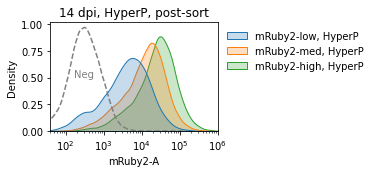

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))

# Plot mRuby2
x = 'mRuby2-A'
hue = 'cond'
hue_order = ['mRuby2-low, HyperP','mRuby2-med, HyperP', 'mRuby2-high, HyperP']

# 'mRuby2-low, HyperP','mRuby2-med, HyperP', 'mRuby2-high, HyperP',
sns.kdeplot(data=data_14dpi[(data_14dpi['cond'].isin(['mRuby2-low, HyperP','mRuby2-med, HyperP', 'mRuby2-high, HyperP']))],
    ax=ax, x=x, hue=hue, hue_order=hue_order,
    common_norm=False, log_scale=(True, False),
    fill=True)
palette = {'mRuby2-low':'tab:orange', 'mRuby2-med':'tab:red', 'mRuby2-high':'tab:blue'}


# Plot neg ctrl
sns.kdeplot(data=data_14dpi_ctrl[(data_14dpi_ctrl['cond'] == 'Ctrl-neg')], x=x, common_norm=False,log_scale=(True, False), color='grey', fill=False, linestyle='--')
ax.annotate('Neg', (0.2, 0.5), color='grey', xycoords='axes fraction', ha='center')

# Title
plt.title('14 dpi, HyperP, post-sort')
# Adjust limits
mRuby2_lim = (40, 1*10**6)
ax.set_xlim(mRuby2_lim)

lmap = {'mRuby2-low, HyperP':'mRuby2-low',
        'mRuby2-med, HyperP':'mRuby2-med',
        'mRuby2-high, HyperP': 'mRuby2-high'}
h,l = ax.get_legend_handles_labels()
sns.move_legend(ax,handles=h, labels=l,
    title='', loc='upper left', bbox_to_anchor=(1,1), frameon=False)

plt.savefig(figpath + 'SI/14dpi_mRuby2_dist_hyperP.svg', bbox_inches='tight')